# **Tracking Coastal Erosion with AI: Land Cover Classification and Dynamics from Space Using Machine Learning**

This notebook aims to apply an unsupervised classification algorithm (k-means clustering)  to detect and monitor coastal erosion and land cover changes using satellite imagery. Sentinel-2 data, known for its high resolution, will be used for the analysis.

The study focuses on a 30 km² section of the Saint-Trojan coastal zone in Western France. The analysis will cover three distinct dates:

- 27th July 2020

- 12th July 2022

- 7th April 2025

This time frame enables a comprehensive comparison of the coastal area's evolution over the years.



![biscay](https://raw.githubusercontent.com/monikagonciarz/AI4EO_final_project/main/images/biscay.png)

## Preparation


As the first step, the notebook must be mounted on your Google Drive, which can be done with the cell below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Enviromental Cost Estimation - Initiation of Calculations
Run the **two cells** below to initialise a time calculation needed to produce a report of the environmental impact of this notebook at the end!

In [26]:
import time
import psutil
import requests
import matplotlib.pyplot as plt
from datetime import datetime

# Estimates and interprets the environmental impact of running a Google Colab notebook.
class ColabEnvironmentalImpact:
    def __init__(self):
        self.start_time = time.time()
        self.start_cpu = psutil.cpu_percent()
        self.start_memory = psutil.virtual_memory().percent
        self.carbon_intensity = 475

# Define approximate carbon intensity (gCO2eq/kWh)
    def get_carbon_intensity(self):
        carbon_intensity = 475

# Estimate energy consumption based on runtime and resource usage. Based on research from https://www.sciencedirect.com/science/article/pii/S0360544219316276
    def estimate_energy_consumption(self, duration_hours, cpu_usage, memory_usage):
        # Average power consumption estimates (Watts)
        idle_power = 50  # Base power for an idle server
        cpu_power = 0.5 * cpu_usage  # Additional power per % CPU usage
        memory_power = 0.1 * memory_usage  # Additional power per % memory usage
        total_power = idle_power + cpu_power + memory_power  # Watts
        # Convert to kWh
        energy_kwh = (total_power * duration_hours) / 1000
        return energy_kwh

# Calculate CO2 emissions based on energy consumption
    def calculate_carbon_footprint(self, energy_kwh):
        return energy_kwh * self.carbon_intensity

# Provide interpretable comparisons for CO2 emissions
    def get_impact_interpretation(self, co2_grams):
        comparisons = {
            'car_km': co2_grams / 170,  # Avg car emits 170g CO2/km
            'smartphone_charges': co2_grams / 8.4,  # Avg smartphone charge = 8.4g CO2
            'tree_days': co2_grams / 3000  # Avg tree absorbs 3000g CO2/month ≈ 100g/day
        }
        return comparisons

# Generate a complete environmental impact report
    def generate_report(self):
        duration_seconds = time.time() - self.start_time
        duration_hours = duration_seconds / 3600

        # Get average resource usage
        avg_cpu = (self.start_cpu + psutil.cpu_percent()) / 2
        avg_memory = (self.start_memory + psutil.virtual_memory().percent) / 2

        # Calculate impacts
        energy_kwh = self.estimate_energy_consumption(duration_hours, avg_cpu, avg_memory)
        co2_grams = self.calculate_carbon_footprint(energy_kwh)
        comparisons = self.get_impact_interpretation(co2_grams)

        # Create visualization
        self.create_impact_visualization(energy_kwh, co2_grams, comparisons)

        # Print report
        print("\n" + "="*50)
        print("GOOGLE COLAB ENVIRONMENTAL IMPACT REPORT")
        print("="*50)
        print(f"Estimated carbon intensity: {self.carbon_intensity} grams of CO2 per kWh")
        print(f"\nDuration: {duration_hours:.2f} hours")
        print(f"Average CPU usage: {avg_cpu:.1f}%")
        print(f"Average memory usage: {avg_memory:.1f}%")
        print(f"\nEstimated energy consumption: {energy_kwh:.4f} kWh")
        print(f"Estimated carbon footprint: {co2_grams:.1f} grams CO2eq")

        print("\nEquivalent to:")
        print(f"- Driving {comparisons['car_km']:.1f} km in an average car")
        print(f"- Charging a smartphone {comparisons['smartphone_charges']:.0f} times")
        print(f"- The amount of CO2 absorbed by a tree in {comparisons['tree_days']:.1f} days")

    def create_impact_visualization(self, energy_kwh, co2_grams, comparisons):
        """Create visualizations of the environmental impact"""
        plt.figure(figsize=(12, 4))

        # Energy and CO2 plot
        plt.subplot(1, 2, 1)
        bars = plt.bar(['Energy [kWh]', 'CO2 [g]'], [energy_kwh, co2_grams], color=['blue', 'green'])
        plt.title('Energy and Carbon Footprint')
        plt.gca().tick_params(left=False, labelleft=False)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

        # Comparisons plot
        plt.subplot(1, 2, 2)
        comparisons_data = {
            'Distance driven\nin a car [km]': comparisons['car_km'],
            'Number of full\nsmartphone charges': comparisons['smartphone_charges'],
            'Days required for a tree\nto absorb the\nequivalent CO2 amount': comparisons['tree_days']
        }
        bars = plt.bar(comparisons_data.keys(), comparisons_data.values(), color='pink')
        plt.title('Equivalent Environmental Impact')
        plt.gca().tick_params(left=False, labelleft=False)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

# Test usage
#if __name__ == "__main__":
    #print("Starting environmental impact monitoring...")
    #monitor = ColabEnvironmentalImpact()
    # Simulate some work
    #input("Press Enter when your notebook has finished running to calculate impact...")
    # Generate report
    #monitor.generate_report()

In [4]:
impact_monitor = ColabEnvironmentalImpact()

To run the code in this notebook, the rasterio package must be installed. This Python library, based on GDAL and Numpy, is specifically designed for reading geospatial raster data, e.g. from SENTINEL-2. To install raterio, run he following cell.

In [5]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 105.1 MB/s eta 0:00:00


Next, a set of functions must be loaded.

In [6]:
import rasterio
import numpy as np

The base file paths for the datasets used in this project are defined below and will be referenced throughout the notebook. Update these paths to match the locations on your device.

In [28]:
# Specify base path
base_path = "/content/drive/MyDrive/AI4EO/Project/"

# Specify file paths for 2020 data
path_2020 = base_path + "S2B_MSIL2A_20200727T105619_N0500_R094_T30TXR_20230430T011345.SAFE/GRANULE/L2A_T30TXR_A017709_20200727T110643/IMG_DATA/R10m/"
bands_paths_2020 = {
    'B8_2020': path_2020 + 'T30TXR_20200727T105619_B08_10m.jp2',
    'B4_2020': path_2020 + 'T30TXR_20200727T105619_B04_10m.jp2',
    'B3_2020': path_2020 + 'T30TXR_20200727T105619_B03_10m.jp2',
    'B2_2020': path_2020 + 'T30TXR_20200727T105619_B02_10m.jp2'
}

# Specify file paths for 2022 data
path_2022 = base_path + "S2A_MSIL2A_20220712T105631_N0510_R094_T30TXR_20240723T232251.SAFE/GRANULE/L2A_T30TXR_A036842_20220712T105925/IMG_DATA/R10m/"
bands_paths_2022 = {
    'B8_2022': path_2022 + 'T30TXR_20220712T105631_B08_10m.jp2',
    'B4_2022': path_2022 + 'T30TXR_20220712T105631_B04_10m.jp2',
    'B3_2022': path_2022 + 'T30TXR_20220712T105631_B03_10m.jp2',
    'B2_2022': path_2022 + 'T30TXR_20220712T105631_B02_10m.jp2'
}

# Specify file paths for 2025 data
path_2025 = base_path + "S2C_MSIL2A_20250407T105641_N0511_R094_T30TXR_20250407T163015.SAFE/GRANULE/L2A_T30TXR_A003067_20250407T110018/IMG_DATA/R10m/"
bands_paths_2025 = {
    'B8_2025': path_2025 + 'T30TXR_20250407T105641_B08_10m.jp2',
    'B4_2025': path_2025 + 'T30TXR_20250407T105641_B04_10m.jp2',
    'B3_2025': path_2025 + 'T30TXR_20250407T105641_B03_10m.jp2',
    'B2_2025': path_2025 + 'T30TXR_20250407T105641_B02_10m.jp2'
}

Below the study area is defined in terms of longitude and latitude.

In [8]:
# Define your bounding box (WGS84)
lon_min, lat_max = -1.24991, 45.82923  # Top-left corner
lon_max, lat_min = -1.19206, 45.77035  # Bottom-right corner

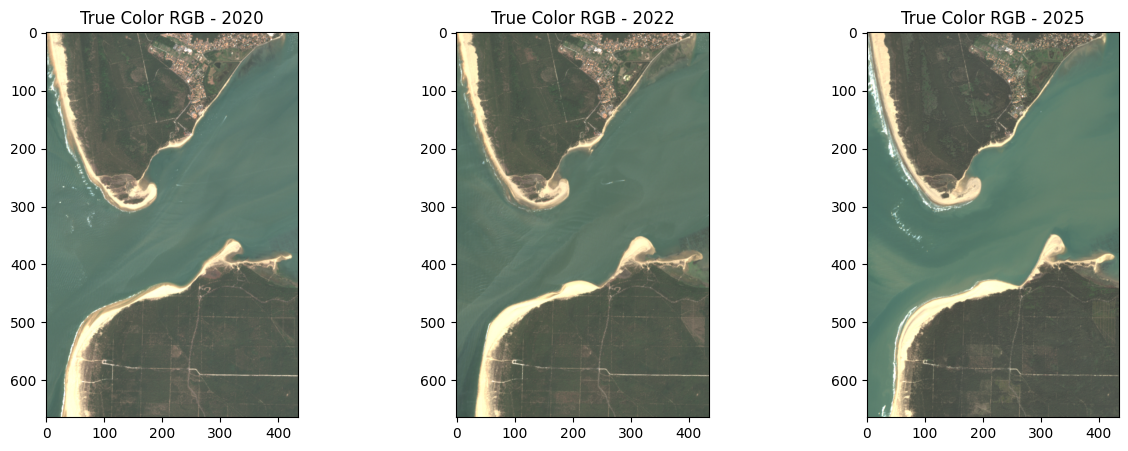

In [36]:
# Visualise study area
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
years = ['2020', '2022', '2025']
bands = ['Band 3\n(Green)', 'Band 4\n(Red)', 'Band 8\n(NIR)']
band_colormaps = ['Greens', 'Reds', 'inferno']
for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']
    with rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B4_{year}']) as red, \
         rasterio.open(bands_paths[f'B2_{year}']) as blue:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Crop to bounding box
        b3 = green.read(1, window=window)
        b4 = red.read(1, window=window)
        b2 = blue.read(1, window=window)

        # Create RGB composite
        rgb = np.dstack([b4, b3, b2])
        rgb_stretched = (rgb / np.percentile(rgb[rgb > 0], 98)) * 255
        rgb_stretched = np.clip(rgb_stretched, 0, 255).astype(np.uint8)

        axes[i].imshow(rgb_stretched)
        axes[i].set_title(f'True Color RGB - {year}')
plt.show()

# Visual representation of the three Bands being used

Below are the 3 color bands (3-green, 4-red, and 6-NIR) used for the analysis.

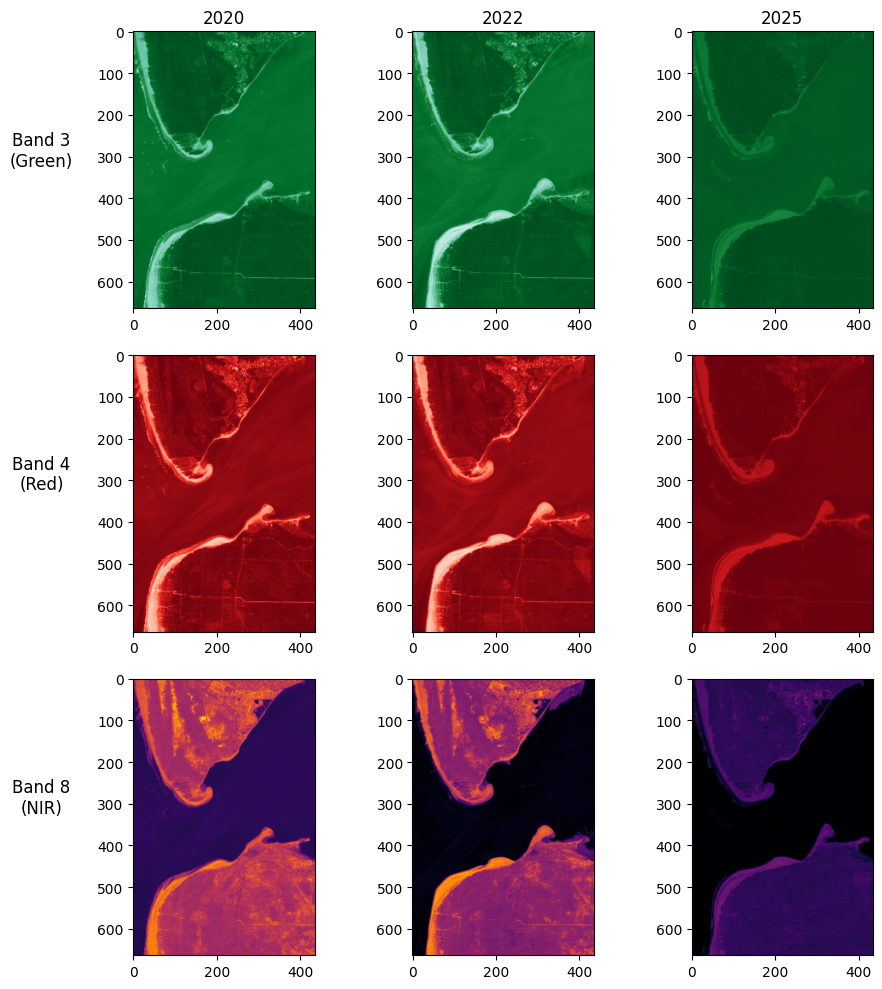

In [9]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
from rasterio.windows import from_bounds

# Initialize figure
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
years = ['2020', '2022', '2025']
bands = ['Band 3\n(Green)', 'Band 4\n(Red)', 'Band 8\n(NIR)']
band_colormaps = ['Greens', 'Reds', 'inferno']

# Loop through years
for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    # Read all three bands
    with rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B4_{year}']) as red, \
         rasterio.open(bands_paths[f'B8_{year}']) as nir:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Read and crop bands
        b3 = green.read(1, window=window)
        b4 = red.read(1, window=window)
        b8 = nir.read(1, window=window)

        # Plot each band
        axes[0, i].imshow(b3, cmap='BuGn_r')
        axes[1, i].imshow(b4, cmap='Reds_r')
        axes[2, i].imshow(b8, cmap='inferno')

        # Set column title (year)
        axes[0, i].set_title(year, size=12)

# Add row titles
for j, band in enumerate(bands):
    axes[j, 0].set_ylabel(band, rotation=0, size=12, labelpad=40)

# Adjust layout
plt.subplots_adjust(wspace=1.1, hspace=15)
plt.tight_layout()
plt.show()


# **Part 1: Coastal Erosion Analysis**

In this section we analyse the extend of coastal erosion by identifying the land and water areas.

# NDWI Water Mask

Firstly, we create a **Normalized Difference Water Index** (NDWI) 'water mask'.

<br>

The NDWI is a common technique used in remote sensing to detect the presence of surface water in satellite imagery (McFeeters, 1996). It works by comparing how much green light (band 3) and near-infrared (NIR, band 8) light is reflected from the Earth's surface. Water tends to reflect more green light and absorb NIR, so the difference between these two bands helps highlight water features.

<br>

The formula is: **NDWI = (Green - NIR) / (Green + NIR)**

<br>

While it is a fast method for identifying water bodies, it does have some limitations. It can struggle in urban areas or when water is mixed with high levels of sediment, often confusing these with other land types (Gao, 1996). In this project, NDWI is a reference method to benchmark our results against. Our aim is to improve upon it using more robust and adaptive machine learning techniques, especially in challenging environments where NDWI alone may fall short.

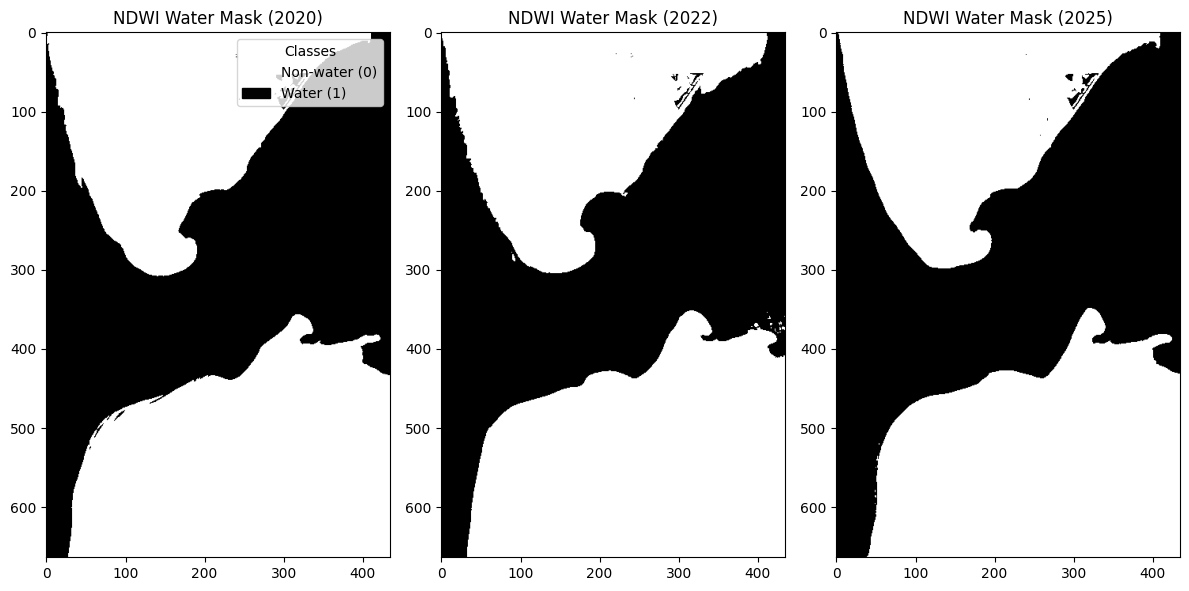

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from rasterio.windows import from_bounds

# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
years = ['2020', '2022', '2025']
threshold = 0.0  # NDWI threshold for water detection

# Create a dictionary to store water masks for each year
water_masks = {}

for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    # Read required bands (B3, B8)
    with rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B8_{year}']) as nir:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Read and crop bands
        b3 = green.read(1, window=window).astype(float)
        b8 = nir.read(1, window=window).astype(float)

        # Calculate NDWI (Normalized Difference Water Index)
        ndwi = (b3 - b8) / (b3 + b8 + 1e-10)  # Small epsilon to avoid division by zero

        # Create water mask based on NDWI
        water_masks[year] = np.where(ndwi > threshold, 1, 0).astype(np.uint8)

        # Plot
        ax = axes[i]
        im = ax.imshow(water_masks[year], cmap='binary')
        ax.set_title(f'NDWI Water Mask ({year})')

        # Add legend to first subplot only
        if i == 0:
            patches = [
                Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Non-water
                Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99))   # Water
            ]
            labels = ['Non-water (0)', 'Water (1)']
            ax.legend(patches, labels, loc='upper right', title='Classes')

plt.tight_layout()
plt.show()


# K-means clustering

In this section we analyse the extent of coastal erosion based on 2 K-means clusters: land and water, utilsing bands 3 and 8 (same as in the NDWI).

- ## K-means clustering using Band 8 (NIR) and Band 3 (green)

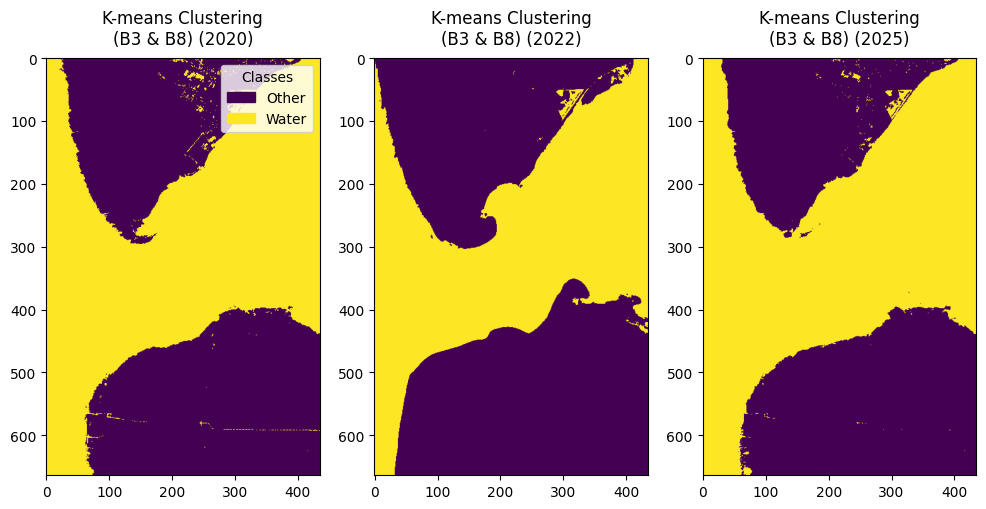

In [12]:
import rasterio
from rasterio.windows import from_bounds
from pyproj import Transformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Initialize figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 3, hspace=0.5)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

years = ['2020', '2022', '2025']
cmap = 'viridis'
n_clusters = 2  # Water vs Land

for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    with rasterio.open(bands_paths[f'B8_{year}']) as nir, \
         rasterio.open(bands_paths[f'B3_{year}']) as green:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", nir.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, nir.transform)

        # Read and crop bands
        b8 = nir.read(1, window=window).astype(float)
        b3 = green.read(1, window=window).astype(float)

        # Prepare feature matrix: [B8, B3]
        X = np.dstack([b8, b3]).reshape((-1, 2))
        valid_mask = (b8 > 0) & (b3 > 0)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[valid_mask.ravel()])

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)

    # Inverse transform to original scale
    centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Identify water cluster by lowest NIR reflectance (B8)
    water_cluster = np.argmin(centers[:, 0])  # NIR is column 0

    # Create labeled image with explicit meaning: 1 = water, 0 = land
    raw_labels = kmeans.labels_
    classified = np.full(b8.shape, -1, dtype=np.uint8)
    classified[valid_mask] = (raw_labels == water_cluster).astype(np.uint8)

    # Save result
    globals()[f'kmeans_results_B8B3_{year}'] = classified

    # Plot
    ax = axes[i]
    im = ax.imshow(classified, cmap=cmap, vmin=0, vmax=1)
    ax.set_title(f'K-means Clustering\n(B3 & B8) ({year})', pad=10)

    # Legend on first subplot
    if i == 0:
        patches = [Rectangle((0, 0), 1, 1, color=plt.cm.viridis(j / (n_clusters - 1)))
                   for j in range(n_clusters)]
        ax.legend(patches, ["Other", "Water"], loc='upper right', title='Classes')

plt.show()


Now, we compare the NDWI water mask with the k-means results to identify discrepancies. We also add the RGB colour composites for enhanced comparison.

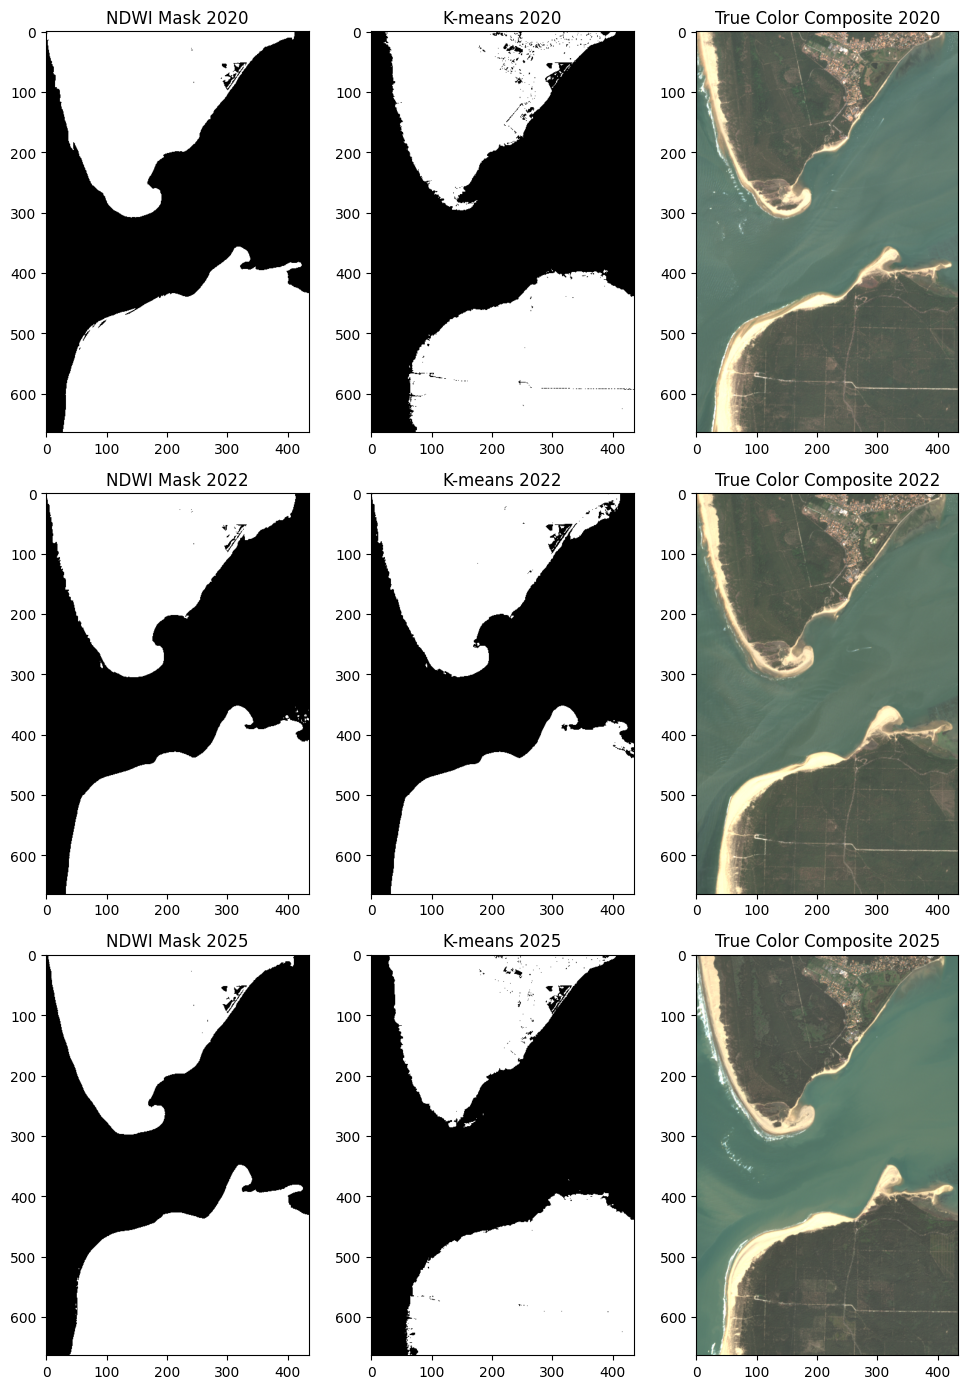

In [46]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from pyproj import Transformer

# Initialize figure with 3 rows and 3 columns for each of the 3 years
fig, axes = plt.subplots(3, 3, figsize=(10, 14))

# Define the years
years = [2020, 2022, 2025]

# Loop through the years for plotting
for i, year in enumerate(years):
    # First row: NDWI masks for each year
    axes[i, 0].imshow(water_masks[str(year)], cmap='binary', vmin=0, vmax=1)
    axes[i, 0].set_title(f'NDWI Mask {year}')

    # Second row: K-means results for each year
    axes[i, 1].imshow(globals()[f'kmeans_results_B8B3_{year}'], cmap='binary', vmin=0, vmax=1)
    axes[i, 1].set_title(f'K-means {year}')

    # Also create RGB composites for each year
    bands_paths = globals()[f'bands_paths_{year}']

    # Read the bands (Blue, Green, Red) for RGB composite
    with rasterio.open(bands_paths[f'B2_{year}']) as blue, \
         rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B4_{year}']) as red:

        # Transform coordinates to pixel space
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Read the data from bands
        b3 = green.read(1, window=window)
        b4 = red.read(1, window=window)
        b2 = blue.read(1, window=window)

    # Create RGB composite
    rgb = np.dstack([b4, b3, b2])
    rgb_stretched = (rgb / np.percentile(rgb[rgb > 0], 98)) * 255
    rgb_stretched = np.clip(rgb_stretched, 0, 255).astype(np.uint8)


    # Plot the RGB composite image on the second row, second column for each year
    axes[i, 2].imshow(rgb_stretched)
    axes[i, 2].set_title(f'True Color Composite {year}')

    # Save the RGB composite as a TIFF file (useful for a potential CNN analysis)
    output_filename = f'RGB_{year}.tif'
    with rasterio.open(output_filename, 'w', driver='GTiff',
                       height=rgb_stretched.shape[0], width=rgb_stretched.shape[1],
                       count=3, dtype=rgb_stretched.dtype, crs=blue.crs, transform=blue.transform) as dst:
        # Write each band to the output file (RGB: Red, Green, Blue)
        dst.write((b4 * 255).astype(np.uint8), 1)  # Red band
        dst.write((b3 * 255).astype(np.uint8), 2)  # Green band
        dst.write((b2 * 255).astype(np.uint8), 3)  # Blue band

plt.tight_layout()
plt.show()

Below, classification matrices and reports are computed to assess the accuracy with which k-means recreate the erosion patterns foreach analysed year.


2020 Classification Report:
              precision    recall  f1-score   support

    Land (0)       1.00      0.87      0.93    159596
   Water (1)       0.86      1.00      0.92    129244

    accuracy                           0.93    288840
   macro avg       0.93      0.93      0.93    288840
weighted avg       0.94      0.93      0.93    288840


2022 Classification Report:
              precision    recall  f1-score   support

    Land (0)       1.00      0.99      0.99    164758
   Water (1)       0.98      1.00      0.99    124082

    accuracy                           0.99    288840
   macro avg       0.99      0.99      0.99    288840
weighted avg       0.99      0.99      0.99    288840


2025 Classification Report:
              precision    recall  f1-score   support

    Land (0)       1.00      0.88      0.93    157374
   Water (1)       0.87      1.00      0.93    131466

    accuracy                           0.93    288840
   macro avg       0.94      0.94      0.

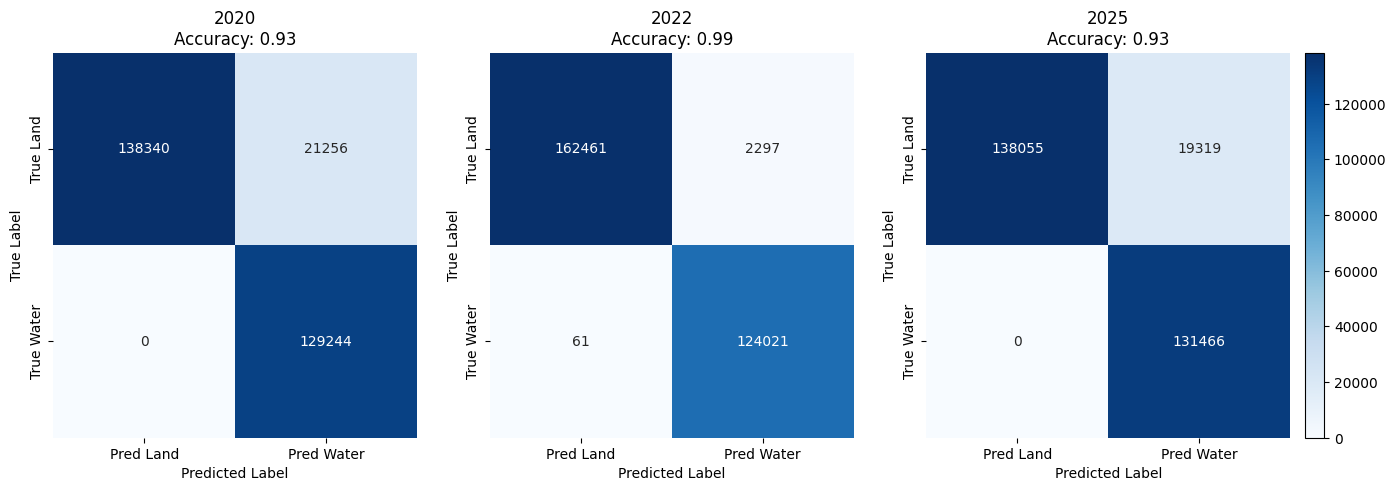

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
years = ['2020', '2022', '2025']
metrics = {}  # To store accuracy scores

for i, year in enumerate(years):
    # Data preprocessing
    mask_ndwi = water_masks[year]
    kmeans_results = globals()[f'kmeans_results_B8B3_{year}']

    # Convert to binary (0=land, 1=water)
    kmeans_binary = np.where(kmeans_results > 0, 1, 0)
    ndwi_binary = np.where(mask_ndwi > 0, 1, 0)

    # Flatten arrays
    ndwi_flat = ndwi_binary.flatten()
    kmeans_flat = kmeans_binary.flatten()

    # Compute metrics
    cm = confusion_matrix(ndwi_flat, kmeans_flat)
    accuracy = accuracy_score(ndwi_flat, kmeans_flat)
    metrics[year] = accuracy

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Pred Land', 'Pred Water'],
                yticklabels=['True Land', 'True Water'],
                ax=axes[i], cbar=False)
    axes[i].set_title(f"{year}\nAccuracy: {accuracy:.2f}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

    # Print classification report
    print(f"\n{year} Classification Report:")
    print(classification_report(ndwi_flat, kmeans_flat,
                              target_names=['Land (0)', 'Water (1)']))

# Add colorbar
fig.colorbar(axes[0].collections[0], ax=axes, location='right', pad=0.01)
plt.show()

# **Part 2: Land Cover Change Analysis**

In this section we focus on a more detailed analysis, including 3 classes: water, sand, and vegetation. This allows for an enhanced comparison of the effects of erosion on different land types.

# NDVI Vegetation Mask

To do this, a 'vegetation mask' is made by introducing another index: the **Normalized Difference Vegetation Index** (NDVI).

The NDVI is a widely used vegetation indicator that helps assess the presence and health of green vegetation using satellite imagery. It compares the difference between near-infrared light (band 8, which vegetation strongly reflects) and red light (band 4, which vegetation absorbs).

The formula is: **NDVI = (NIR - Red) / (NIR + Red)**


High NDVI values typically indicate dense, healthy vegetation, while lower values suggest sparse or stressed plant cover. NDVI is especially useful in land cover classification, agriculture, and environmental monitoring due to its simplicity and effectiveness.



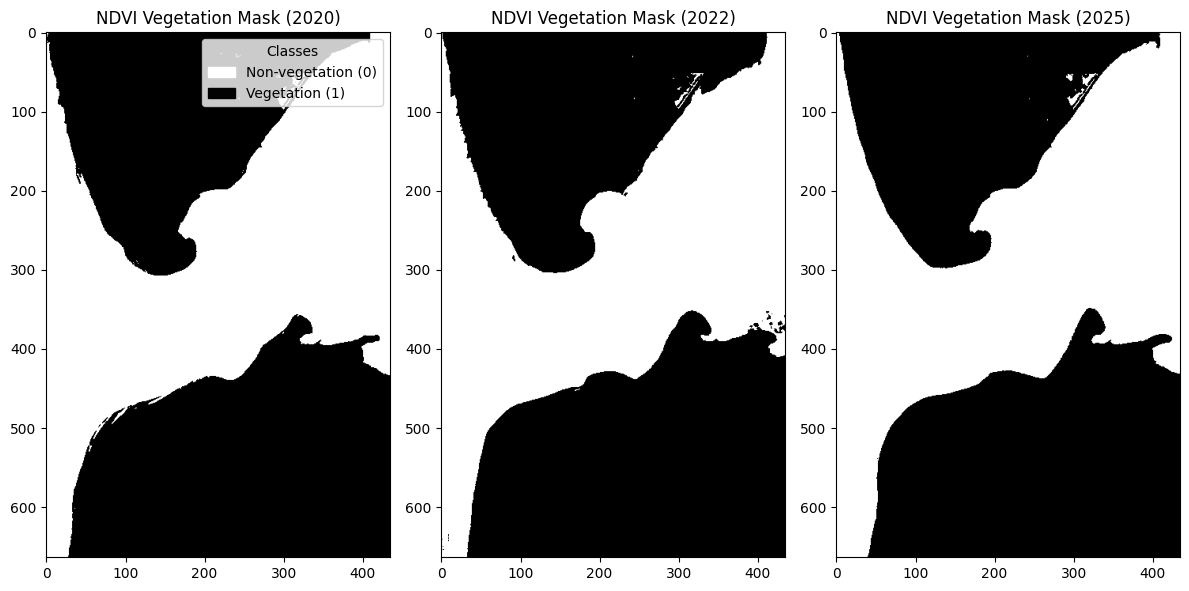

In [15]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyproj import Transformer
from rasterio.windows import from_bounds

# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
years = ['2020', '2022', '2025']
threshold = 0.0  # NDVI threshold for vegetation detection

# Create a dictionary to store vegetation masks for each year
vegetation_masks = {}

for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    # Read required bands (B4, B8)
    with rasterio.open(bands_paths[f'B4_{year}']) as red, \
         rasterio.open(bands_paths[f'B8_{year}']) as nir:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Read and crop bands
        b4 = red.read(1, window=window).astype(float)
        b8 = nir.read(1, window=window).astype(float)

        # Calculate NDVI (Normalized Difference Vegetation Index)
        ndvi = (b8 - b4) / (b8 + b4 + 1e-10)  # Small epsilon to avoid division by zero

        # Create vegetation mask based on NDVI
        vegetation_masks[year] = np.where(ndvi > threshold, 1, 0).astype(np.uint8)

        # Plot
        ax = axes[i]
        im = ax.imshow(vegetation_masks[year], cmap='binary')
        ax.set_title(f'NDVI Vegetation Mask ({year})')

        # Add legend to first subplot only
        if i == 0:
            patches = [
                Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Non-vegetation
                Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99))   # Vegetation
            ]
            labels = ['Non-vegetation (0)', 'Vegetation (1)']
            ax.legend(patches, labels, loc='upper right', title='Classes')

plt.tight_layout()
plt.show()


- ## K-means clustering using Band 8 (NIR) and Band 4 (red) (2 clusters)

This time we begin the k-means analysis by defining 2 clusters: vegetation and other, while using bands 4 and 8 (same as in the NDVI).

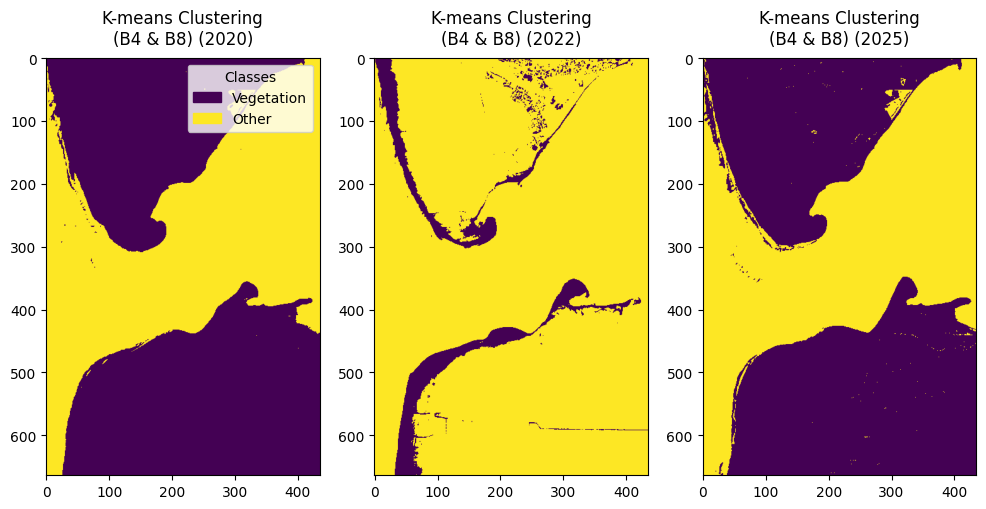

In [16]:
import rasterio
from rasterio.windows import from_bounds
from pyproj import Transformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Initialize figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 3, hspace=0.5)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

years = ['2020', '2022', '2025']
cmap = 'viridis'
n_clusters = 2  # Vegetation vs Other

for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    with rasterio.open(bands_paths[f'B8_{year}']) as nir, \
         rasterio.open(bands_paths[f'B4_{year}']) as red:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", nir.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, nir.transform)

        # Read and crop bands
        b8 = nir.read(1, window=window).astype(float)
        b4 = red.read(1, window=window).astype(float)

        # Prepare feature matrix: [B8, B4]
        X = np.dstack([b8, b4]).reshape((-1, 2))
        valid_mask = (b8 > 0) & (b4 > 0)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[valid_mask.ravel()])

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)

    # Inverse transform to original scale
    centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Identify vegetation cluster by lowest NIR reflectance (B8)
    vegetation_cluster = np.argmin(centers[:, 0])  # NIR is column 0

    # Create labeled image with explicit meaning: 1 = vegetation, 0 = other
    raw_labels = kmeans.labels_
    classified = np.full(b8.shape, -1, dtype=np.uint8)
    classified[valid_mask] = (raw_labels == vegetation_cluster).astype(np.uint8)

    # Save result
    globals()[f'kmeans_results_B8B4_{year}'] = classified

    # Plot
    ax = axes[i]
    im = ax.imshow(classified, cmap=cmap, vmin=0, vmax=1)
    ax.set_title(f'K-means Clustering\n(B4 & B8) ({year})', pad=10)

    # Legend on first subplot
    if i == 0:
        patches = [Rectangle((0, 0), 1, 1, color=plt.cm.viridis(j / (n_clusters - 1)))
                   for j in range(n_clusters)]
        ax.legend(patches, ["Vegetation", "Other"], loc='upper right', title='Classes')

plt.show()


- ## K-means clustering using Band 8 (NIR) and Band 4 (red) (3 clusters)

Then, we enhance the analysis by defining 3 clusters instead of 2 for k-means: water, vegetation, and sand.

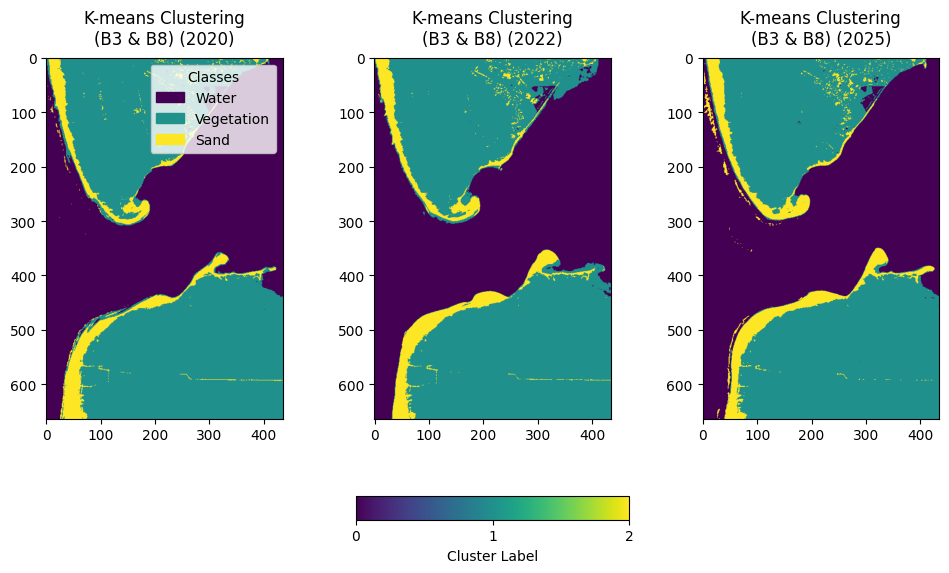

In [17]:
import rasterio
from rasterio.windows import from_bounds
from pyproj import Transformer
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Initialize figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[15, 1], hspace=0.4)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cbar_ax = fig.add_subplot(gs[1, 1])  # Centered colorbar

years = ['2020', '2022', '2025']
cmap = 'viridis'
n_clusters = 3

# Store cluster stats for consistent labeling
all_centers = []

for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    # Read both Band 3 (Green) and Band 8 (NIR)
    with rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B8_{year}']) as nir:

        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Read both bands
        b3 = green.read(1, window=window).astype(float)
        b8 = nir.read(1, window=window).astype(float)

        # Combine bands for clustering (using both B3 and B8)
        X = np.dstack([b3, b8]).reshape((-1, 2))
        valid_mask = (b3 > 0) & (b8 > 0)

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X[valid_mask.ravel()])

    # Store cluster centers
    centers = kmeans.cluster_centers_
    all_centers.append(centers)

    # Sort clusters by NIR (Band 8) reflectance (dark to bright)
    sorted_indices = np.argsort(centers[:, 1])  # Using Band 8 (second column) for sorting

    # Remap labels
    label_mapping = {old: new for new, old in enumerate(sorted_indices)}
    labels = np.array([label_mapping[label] for label in kmeans.labels_])

    labels_image = np.full(b3.shape, -1, dtype=int)
    labels_image[valid_mask] = labels

    globals()[f'kmeans_results_B3B8_3clusters_{year}'] = labels_image

    ax = axes[i]
    im = ax.imshow(labels_image, cmap=cmap, vmin=0, vmax=n_clusters-1)
    ax.set_title(f'K-means Clustering\n(B3 & B8) ({year})', pad=10)

    # Add legend to first subplot
    if i == 0:
        patches = [Rectangle((0, 0), 1, 1, color=plt.cm.viridis(j/(n_clusters-1)))
                 for j in range(n_clusters)]
        labels = [
            "Water",  # Darkest in NIR (Cluster 0)
            "Vegetation",       # Medium in NIR (Cluster 1)
            "Sand"         # Brightest in NIR (Cluster 2)
        ]
        ax.legend(patches, labels, loc='upper right', title='Classes')

# Colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                   label='Cluster Label',
                   aspect=30, ticks=[0, 1, 2])
cbar_ax.xaxis.set_label_position('bottom')

plt.show()

- ## K-means Classification utilising all Bands (3, 4, and 8), the NDWI water mask and the NDVI vegetation mask

For a final k-meand classification, all 3 bands and 3 clusters are used, while also applying the NDWI and NDVI masks.

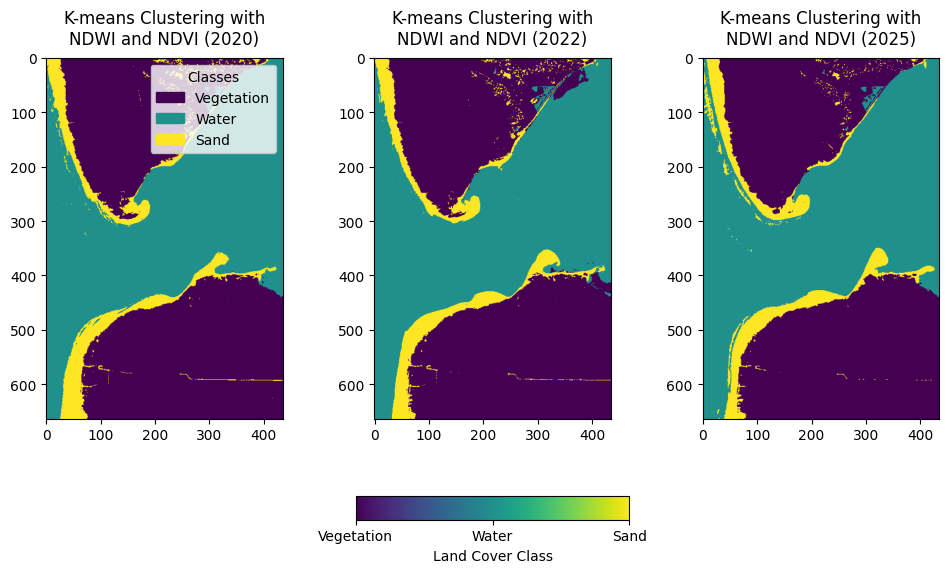

In [19]:
import rasterio
from rasterio.windows import from_bounds
from pyproj import Transformer
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.preprocessing import StandardScaler

# Initialize figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 3, height_ratios=[15, 1], hspace=0.4)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cbar_ax = fig.add_subplot(gs[1, 1])  # Centered colorbar

years = ['2020', '2022', '2025']
cmap = 'viridis'
n_clusters = 3  # Vegetation, Water, Sand

for i, year in enumerate(years):
    bands_paths = globals()[f'bands_paths_{year}']

    # Read all three bands (B3=Green, B4=Red, B8=NIR)
    with rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B4_{year}']) as red, \
         rasterio.open(bands_paths[f'B8_{year}']) as nir:

        # Transform bounds to pixel coordinates
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        # Read and crop bands
        b3 = green.read(1, window=window).astype(float)
        b4 = red.read(1, window=window).astype(float)
        b8 = nir.read(1, window=window).astype(float)

        # Calculate vegetation/water indices
        ndvi = (b8 - b4) / (b8 + b4 + 1e-10)  # Vegetation index
        ndwi = (b3 - b8) / (b3 + b8 + 1e-10)  # Water index

        # Prepare 5D feature matrix: [B3, B4, B8, NDVI, NDWI]
        X = np.dstack([b3, b4, b8, ndvi, ndwi]).reshape((-1, 5))
        valid_mask = (b3 > 0) & (b4 > 0) & (b8 > 0)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[valid_mask.ravel()])

    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)

    # Interpret clusters based on spectral characteristics
    centers = scaler.inverse_transform(kmeans.cluster_centers_)

    # Identify vegetation cluster (highest NDVI)
    veg_cluster = np.argmax(centers[:, 3])

    # Identify water cluster (highest NDWI)
    water_cluster = np.argmax(centers[:, 4])

    # Remap labels to consistent order
    label_map = {
        veg_cluster: 0,
        water_cluster: 1,
        [x for x in range(n_clusters) if x not in [veg_cluster, water_cluster]][0]: 2
    }


    labels = np.array([label_map[x] for x in kmeans.labels_])


    # Apply to image
    labels_image = np.full(b3.shape, -1, dtype=int)
    labels_image[valid_mask] = labels

    # Enhance with index thresholds (optional)
    labels_image[(ndvi > 0.5) & (valid_mask)] = 0
    labels_image[(ndwi > 0.2) & (valid_mask)] = 1

    # Save result
    globals()[f'kmeans_results_NDWI_NDVI_3clusters_{year}'] = labels_image

    # Plot
    ax = axes[i]
    im = ax.imshow(labels_image, cmap=cmap, vmin=0, vmax=n_clusters-1)
    ax.set_title(f'K-means Clustering with\nNDWI and NDVI ({year})', pad=10)

    # Add legend to first subplot
    if i == 0:
        patches = [Rectangle((0, 0), 1, 1, color=plt.cm.viridis(j/(n_clusters-1)))
                 for j in range(n_clusters)]
        class_labels = ["Vegetation", "Water", "Sand"]
        ax.legend(patches, class_labels, loc='upper right', title='Classes')

    # Colorbar
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',
                   label='Land Cover Class', aspect=30,
                   ticks=[0, 1, 2])
    cbar.ax.set_xticklabels(["Vegetation", "Water", "Sand"])
    cbar_ax.xaxis.set_label_position('bottom')

plt.show()


As before, classification matrices and report are generated to assess k-means accuracy, this time comparing the NDVI with k-means.


2020 Classification Report:
              precision    recall  f1-score   support

    Land (0)       0.99      0.99      0.99    129868
   Water (1)       0.99      0.99      0.99    158972

    accuracy                           0.99    288840
   macro avg       0.99      0.99      0.99    288840
weighted avg       0.99      0.99      0.99    288840


2022 Classification Report:
              precision    recall  f1-score   support

    Land (0)       0.99      1.00      0.99    124314
   Water (1)       1.00      0.99      0.99    164526

    accuracy                           0.99    288840
   macro avg       0.99      0.99      0.99    288840
weighted avg       0.99      0.99      0.99    288840


2025 Classification Report:
              precision    recall  f1-score   support

    Land (0)       0.99      0.99      0.99    131824
   Water (1)       0.99      0.99      0.99    157016

    accuracy                           0.99    288840
   macro avg       0.99      0.99      0.

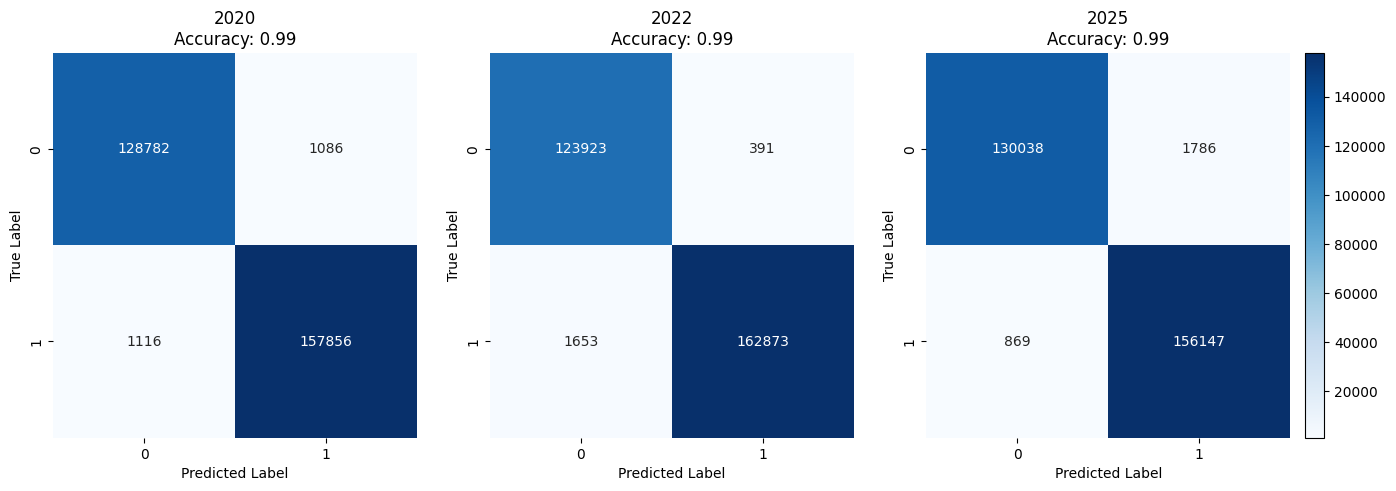

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(19, 5))
years = ['2020', '2022', '2025']
metrics = {}  # To store accuracy scores

for i, year in enumerate(years):
    # Data preprocessing
    mask_ndwi = vegetation_masks[year]
    kmeans_results = globals()[f'kmeans_results_B3B8_3clusters_{year}']

    # Convert to binary (0=land, 1=water)
    kmeans_binary = np.where(kmeans_results > 0, 1, 0)
    ndwi_binary = np.where(mask_ndwi > 0, 1, 0)

    # Flatten arrays
    ndwi_flat = ndwi_binary.flatten()
    kmeans_flat = kmeans_binary.flatten()

    # Compute metrics
    cm = confusion_matrix(ndwi_flat, kmeans_flat)
    accuracy = accuracy_score(ndwi_flat, kmeans_flat)
    metrics[year] = accuracy

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['0', '1'],
                yticklabels=['0', '1'],
                ax=axes[i], cbar=False)
    axes[i].set_title(f"{year}\nAccuracy: {accuracy:.2f}")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

    # Print classification report
    print(f"\n{year} Classification Report:")
    print(classification_report(ndwi_flat, kmeans_flat,
                              target_names=['Land (0)', 'Water (1)']))

# Add colorbar
fig.colorbar(axes[0].collections[0], ax=axes, location='right', pad=0.01)
plt.show()

###**Feature Space Clustering**

Subsequently, feature space clustering plots are created. These visualizations illustrate how pixels are grouped based on their spectral characteristics (based on NDVI and NDWI masks), allowing us to observe the separation between different land cover types such as water, vegetation, and sand in each year.

*(idea inspired by Balaji, 2022)*

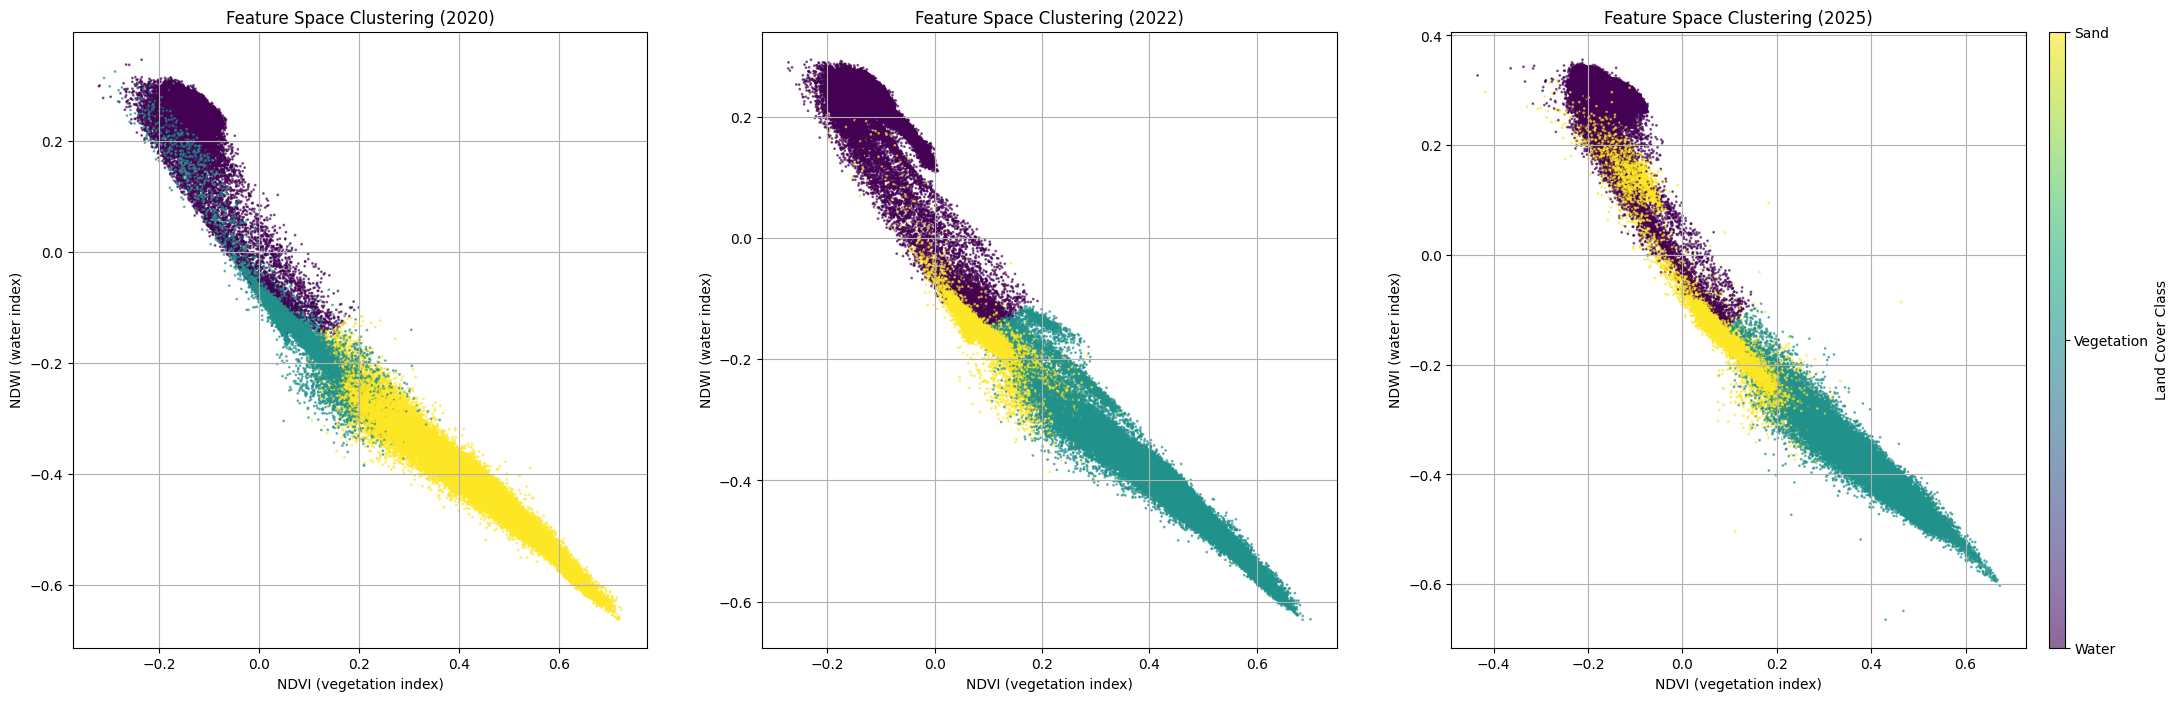

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import rasterio
from rasterio.windows import from_bounds
from pyproj import Transformer

# Initialize figure
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
years = ['2020', '2022', '2025']
cmap = 'viridis'

for i, year in enumerate(years):
    # Read bands
    bands_paths = globals()[f'bands_paths_{year}']
    with rasterio.open(bands_paths[f'B3_{year}']) as green, \
         rasterio.open(bands_paths[f'B4_{year}']) as red, \
         rasterio.open(bands_paths[f'B8_{year}']) as nir:

        # Transform bounds
        transformer = Transformer.from_crs("EPSG:4326", green.crs, always_xy=True)
        x_min, y_min = transformer.transform(lon_min, lat_min)
        x_max, y_max = transformer.transform(lon_max, lat_max)
        window = from_bounds(x_min, y_min, x_max, y_max, green.transform)

        b3 = green.read(1, window=window).astype(float)
        b4 = red.read(1, window=window).astype(float)
        b8 = nir.read(1, window=window).astype(float)

    # Calculate indices
    ndvi = (b8 - b4) / (b8 + b4 + 1e-10)
    ndwi = (b3 - b8) / (b3 + b8 + 1e-10)

    # Stack features and filter valid pixels
    valid_mask = (b3 > 0) & (b4 > 0) & (b8 > 0)
    X = np.stack([b3, b4, b8, ndvi, ndwi], axis=-1)
    X_flat = X[valid_mask]
    ndvi_flat = ndvi[valid_mask]
    ndwi_flat = ndwi[valid_mask]

    # Standardize and cluster
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
    labels = kmeans.labels_

    # Plot
    scatter = axes[i].scatter(ndvi_flat, ndwi_flat, c=labels, cmap=cmap,
                            s=1, alpha=0.6, vmin=0, vmax=2)
    axes[i].set_xlabel('NDVI (vegetation index)')
    axes[i].set_ylabel('NDWI (water index)')
    axes[i].set_title(f'Feature Space Clustering ({year})')
    axes[i].grid(True)

    # Add colorbar to last subplot
    if i == 2:
        cbar = fig.colorbar(scatter, ax=axes, ticks=[0, 1, 2],
                           pad=0.01, aspect=40)
        cbar.ax.set_yticklabels(["Water", "Vegetation", "Sand"])
        cbar.set_label('Land Cover Class')

plt.show()

# **Environmental Cost Estimate**

Run the cell below to generate a detailed report on the environmental impact of this notebook, including the **energy consumed** (in kWh) and the associated **carbon footprint** (in grams of CO2).


To help **contextualize the data**, the report also includes visual plots and relatable comparisons, such as the equivalent distance driven in a car, the number of full smartphone charges, and the number of days it would take for a tree to absorb the same amount of CO2.



It is worth noting that activities like downloading data, accessing additonal resources, and leveraging AI for assistance which were done in order to create this notebook are **not easy to quantify**. However they undeniably contribute to a higher environmental cost. These processes typically require substantial computational power and energy consumption, which increases the carbon footprint.



These insights can encourage reflection on the environmental cost of using AI and machine learning, and help *evaluate whether such usage is a responsible allocation of natural resources*.

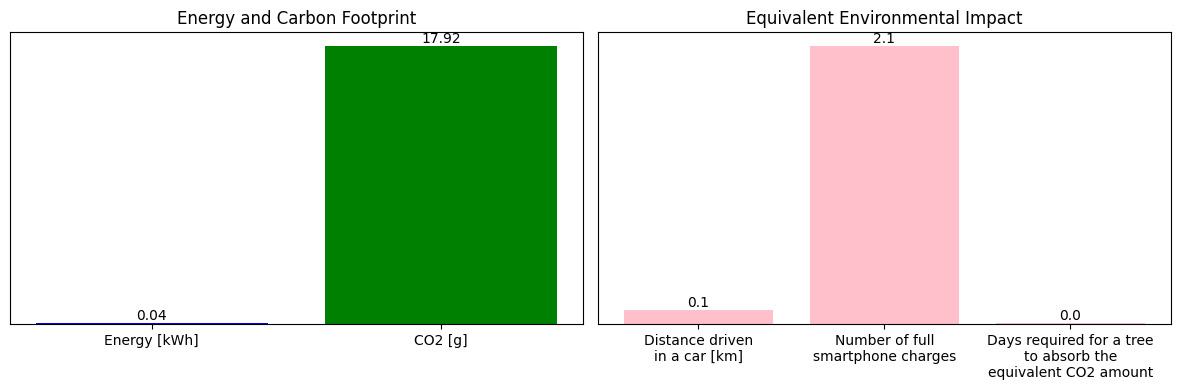


GOOGLE COLAB ENVIRONMENTAL IMPACT REPORT
Estimated carbon intensity: 475 grams of CO2 per kWh

Duration: 0.65 hours
Average CPU usage: 13.3%
Average memory usage: 13.2%

Estimated energy consumption: 0.0377 kWh
Estimated carbon footprint: 17.9 grams CO2eq

Equivalent to:
- Driving 0.1 km in an average car
- Charging a smartphone 2 times
- The amount of CO2 absorbed by a tree in 0.0 days


In [49]:
impact_monitor.generate_report()